Affichage (nuage) des zones atteignables par un joueur

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from PIL import Image, ImageDraw, ImageFont
from concave_hull import concave_hull
import alphashape
import os

from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import splprep, splev

from config import chemin_tt_espace

from fonctions_positions import atteintes_3D, atteintes_lateralite, banane_alexis
from config import chemin_pipeline, chemin_tt_espace

In [25]:
compet='2024_WttSmash_Singapour'
match='ALEXIS-LEBRUN_vs_MA-LONG'

atteintes_jA, atteintes_jB = atteintes_3D(compet, match)

compet="2024_WttSmash_Singapour"
nom_match=match#'ALEXIS-LEBRUN_vs_MA-LONG'
#match=os.path.join(chemin_pipeline,compet,nom_match,nom_match)
if not os.path.exists(os.path.join('{}'.format(match))):
    os.makedirs('{}'.format(match))

In [3]:
height, width = 400, 800
size=10
image_jA=np.ones((height, width,3), np.uint8)*255
image_jA=Image.fromarray(image_jA)
image_jB=image_jA.copy()
draw_jA = ImageDraw.Draw(image_jA)
draw_jB = ImageDraw.Draw(image_jB)
xj, yj = width/2, height/2
draw_jA.ellipse((xj - size, yj - size, xj + size, yj + size), fill="black")
draw_jB.ellipse((xj - size, yj - size, xj + size, yj + size), fill="black")

Text(0.5, 1.0, 'évolution de la précision en fonction du temps de seuil')

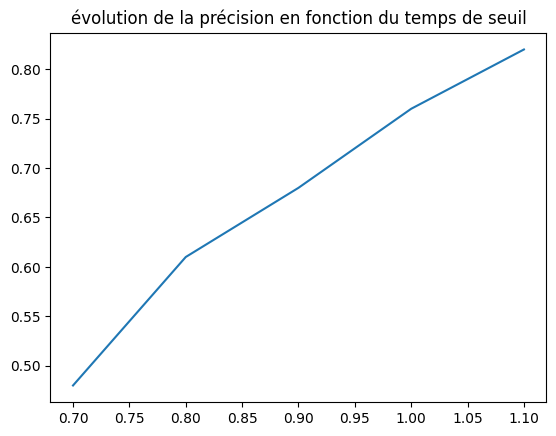

In [4]:
plt.plot([0.7, 0.8, 0.9, 1, 1.1], [0.48, 0.61, 0.68, 0.76, 0.82])
plt.title('évolution de la précision en fonction du temps de seuil')

In [22]:
with open('{}_annotation_enrichi.csv'.format(os.path.join(chemin_pipeline,compet,nom_match,nom_match)), newline='') as fichier_annotations :
    annotations=[]
    reader=csv.reader(fichier_annotations)
    for ligne in reader :
        annotations.append(ligne)

print('liste des données :',annotations[0])
print("exemple d'une donnée :", annotations[1])

liste des données : ['nom', 'debut', 'fin', 'genre', 'lateralite', 'set', 'systeme', 'coup', 'type_service', 'type_coup', 'zone_jeu', 'faute', 'effet_coup', 'coor_balle_x', 'coor_balle_y', 'coor_balle_z', 'joueur_frappe', 'joueur_sur', 'coor_frappe_x', 'coor_frappe_y', 'coor_frappe_z', 'time_frappe', 'premier_rebond_x', 'premier_rebond_y', 'premier_rebond_z', 'time_premier_rebond', 'probleme_annotation', 'num_coup', 'winner', 'premier_topspin', 'serveur', 'relanceur', 'pos_balle_x_prece', 'pos_balle_y_prece', 'pos_balle_z_prece', 'pos_joueur_0_x', 'pos_joueur_0_y', 'pos_joueur_0_z', 'pos_joueur_1_x', 'pos_joueur_1_y', 'pos_joueur_1_z', 'pos_joueur_2_x', 'pos_joueur_2_y', 'pos_joueur_2_z', 'pos_joueur_3_x', 'pos_joueur_3_y', 'pos_joueur_3_z', 'dist_equipe_1_x', 'dist_equipe_1_y', 'dist_equipe_2_x', 'dist_equipe_2_y', 'dist_eucl_equipe_1', 'dist_eucl_equipe_2', 'num_point', 'service_lateralite', 'service_zone', 'remise_lateralite', 'remise_effet_coup', 'remise_zone', 'faute_du_point', 'f

In [11]:
if annotations[0][26]=='probleme_annotation':
    C=1
else:
    C=0

In [26]:
set_point=[] # num set, num pt
set_point.append([1,0])
for i in range(2,len(annotations)):
    if annotations[i][52+C]!=annotations[i-1][52+C]:
        set_point.append([int(annotations[i][5]), int(annotations[i][52+C])])

coord=[] #xj, yj, xb, yb
for i in range(len(set_point)): #on boucle sur le nb de pts au cours du match
    chemin='{}/{}/{}/clips/set_{}_point_{}'.format(chemin_pipeline,compet, match, set_point[i][0], set_point[i][1])
    
    with open('{}/set_{}_point_{}_annotation.csv'.format(chemin, set_point[i][0], set_point[i][1]), newline='') as fichier :
        set_point_annotation=[]
        reader=csv.reader(fichier)
        for ligne in reader :
            set_point_annotation.append(ligne)

    time_frappe=[] #frame de frappe (sachant que les num de frame reviennent à 0 à chaque début de point dans les clips)
    for j in range(1, len(set_point_annotation)):
        if set_point_annotation[j][8]=='': # on ne prend pas les services
            time_frappe.append(int(set_point_annotation[j][21]))
    
    with open('{}/csv_json_openpose/set_{}_point_{}_zone_joueur_avec_pos_balle.csv'.format(chemin, set_point[i][0], set_point[i][1]), newline='') as fichier :
        set_point_pose=[]
        reader=csv.reader(fichier)
        for ligne in reader :
            set_point_pose.append(ligne)
    
    for j in range(len(time_frappe)):
        if float(set_point_pose[time_frappe[j]*3+1][3]) * float(set_point_annotation[j+2][19]) >0 : # ie j0 et balle du même côté de la table
            if -float(set_point_annotation[j+2][19]) >0 : # et du côté des y positifs
                coord.append([-float(set_point_pose[time_frappe[j]*3+1][2]), float(set_point_pose[time_frappe[j]*3+1][3]), -float(set_point_annotation[j+2][18]), float(set_point_annotation[j+2][19])])
            elif -float(set_point_annotation[j+2][19]) <0 :
                coord.append([float(set_point_pose[time_frappe[j]*3+1][2]), -float(set_point_pose[time_frappe[j]*3+1][3]), float(set_point_annotation[j+2][18]), -float(set_point_annotation[j+2][19])])
        elif float(set_point_pose[time_frappe[j]*3+2][3]) * float(set_point_annotation[j+2][19]) >0 :
            if -float(set_point_annotation[j+2][19]) >0 :
                coord.append([-float(set_point_pose[time_frappe[j]*3+2][2]), float(set_point_pose[time_frappe[j]*3+2][3]), -float(set_point_annotation[j+2][18]), float(set_point_annotation[j+2][19])])
            elif -float(set_point_annotation[j+2][19]) <0 :
                coord.append([float(set_point_pose[time_frappe[j]*3+2][2]), -float(set_point_pose[time_frappe[j]*3+2][3]), float(set_point_annotation[j+2][18]), -float(set_point_annotation[j+2][19])])
    

atteintes = []

for i in range(len(coord)):
    atteintes.append([float(coord[i][2]-coord[i][0]), float(coord[i][3]-coord[i][1])])

(-0.5, 799.5, 399.5, -0.5)

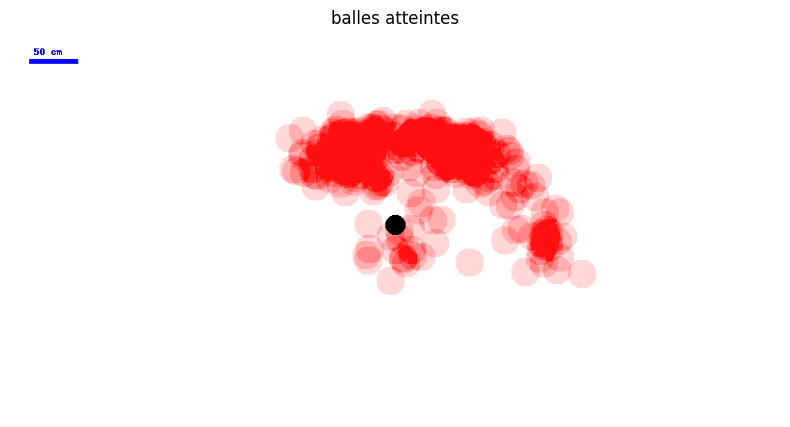

In [30]:
im=image_jA.copy()
px=im.load()

R=15

for i in range(len(atteintes)):
    xb, yb = atteintes[i][0] +xj, -atteintes[i][1] +yj
    for l in range(2*R):
        for L in range(2*R):
            if (L-R)**2+(l-R)**2<R**2:
                if xb+L-R<width and yb+l-R<height and xb+L-R>0 and yb+l-R>0:
                    g=int(px[xb+L-R,yb+l-R][1]-40)
                    b=int(px[xb+L-R,yb+l-R][2]-40)
                    if g>0 and b>0:
                        im.putpixel([int(xb+L-R),int(yb+l-R)],(255,g,b))
                        px=im.load()
    draw=ImageDraw.Draw(im)
    draw.line([(20,30),(70,30)], fill='blue', width=5)
    im.save('output/match_{}/nuage/nuage_{}.png'.format(match, i))

draw.text((25,15), '50 cm', fill='blue')
plt.figure(figsize=(10,5))
plt.imshow(im)
plt.title('balles atteintes')
plt.axis('off')

In [31]:
height, width = 400, 800
size=10
im=np.ones((height, width,3), np.uint8)*255
im=Image.fromarray(im)
xj, yj = width/2, height/2
draw=ImageDraw.Draw(im)
draw.ellipse((xj - size, yj - size, xj + size, yj + size), fill="black")
im.save(os.path.join('image_vierge_nuage.png'))

Création zone de frappe (enveloppe banane)

In [32]:
balles_frappees_jA, balles_frappees_jB = [], []
for i in range(len(atteintes_jA)):
    balles_frappees_jA.append(np.array([atteintes_jA[i][0]+xj, atteintes_jA[i][1]+yj])) # /!\ j'enlève le - sur les y parce qu'en utilisant pyplot, le référentiel est en bas à gauche et non en haut à gauche pour pour Pillow
for i in range(len(atteintes_jB)):
    balles_frappees_jB.append(np.array([atteintes_jB[i][0]+xj, -atteintes_jB[i][1]+yj]))
balles_frappees_jA=np.array(balles_frappees_jA)
balles_frappees_jB=np.array(balles_frappees_jB)

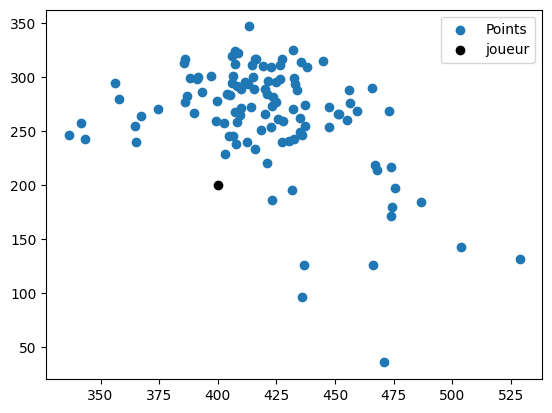

In [33]:
# méthode 1 : concave_hull

hull_points_jA=concave_hull(balles_frappees_jA)
hull_points_jB=concave_hull(balles_frappees_jB)

plt.scatter(balles_frappees_jA[:, 0], balles_frappees_jA[:, 1], label='Points')
plt.scatter(400,200, color='k', label='joueur')
#plt.plot(hull_points_jA[:, 0], hull_points_jA[:, 1], 'r--', lw=2, label='Concave Hull')
#plt.fill(hull_points_jA[:, 0], hull_points_jA[:, 1], 'r', alpha=0.1)
plt.legend()
plt.show()

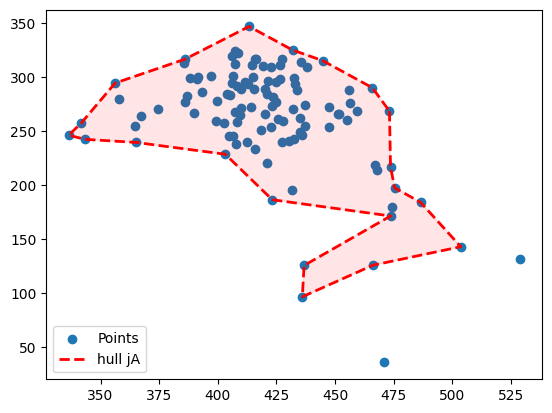

In [34]:
# méthode 2 : alphashape

alpha = 0.033
hull_points_jA = alphashape.alphashape(balles_frappees_jA, alpha)

def plot_polygon(ax, polygon, color='r', alpha=0.1):
    if isinstance(polygon, Polygon):
        hull_points = np.array(polygon.exterior.coords)
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'r--', lw=2, label='hull jA')
        ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.1)
    elif isinstance(polygon, MultiPolygon):
        for poly in polygon.geoms:
            plot_polygon(ax, poly, color, alpha)

fig, ax = plt.subplots()
ax.scatter(balles_frappees_jA[:, 0], balles_frappees_jA[:, 1], label='Points')
plot_polygon(ax, hull_points_jA)
ax.legend()
plt.show()

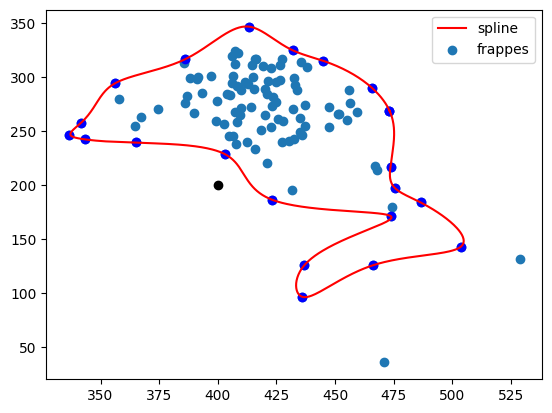

In [35]:
# méthode 2 avancée : lissage par splines

contour_points_liste = []
if isinstance(hull_points_jA, Polygon):
    contour_points_liste.append(np.array(hull_points_jA.exterior.coords))
elif isinstance(hull_points_jA, MultiPolygon):
    for poly in hull_points_jA.geoms:
        contour_points_liste.append(np.array(poly.exterior.coords))

x, y = [], []
for contour_points in contour_points_liste:
    tck, u = splprep([contour_points[:, 0], contour_points[:, 1]], s=2.0, per=True)
    u_nouv = np.linspace(u.min(), u.max(), 1000)
    x_nouv, y_nouv = splev(u_nouv, tck)
    x.append(x_nouv)
    y.append(y_nouv)

fig,ax=plt.subplots()
for contour_points in contour_points_liste:
    plt.plot(contour_points[:, 0], contour_points[:, 1], 'o', color='blue')
for x_nouv, y_nouv in zip(x, y):
    plt.plot(x_nouv, y_nouv, '-', label='spline', color='red')
ax.scatter(balles_frappees_jA[:, 0], balles_frappees_jA[:, 1], color='tab:blue', label='frappes')
ax.scatter(400,200,color='k')
plt.legend()
plt.show()

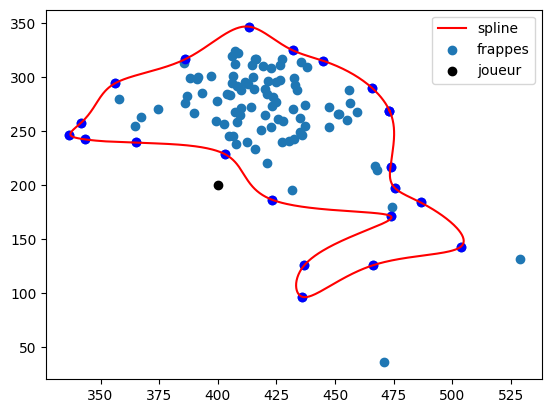

La surface de la banane vaut 1.6351698679667814 m^2.


In [50]:
# méthode 2 avancée ++ : sélection manuelle des pts que l'on souhaite garder (les plus extérieurs)

contour_points_liste = []
if isinstance(hull_points_jA, Polygon):
    contour_points_liste.append(np.array(hull_points_jA.exterior.coords))
elif isinstance(hull_points_jA, MultiPolygon):
    for poly in hull_points_jA.geoms:
        contour_points_liste.append(np.array(poly.exterior.coords))

x, y = [], []
compteur=0
for contour_points in contour_points_liste:
    compteur+=1
    if compteur==2: # la banane c'est le deuxième polygone créé par la fonction alphashape
        contour_points_bis=[]
        for i in [0,2,3,7,12,14,18,20,23,25,26,29,34]: # les pts que je veux garder pour avoir une forme englobante et lisse (en prenant ces pts, la fonction splprep qui lisse par spline une forme 2D crée une forme qui recouvre tous les pts de mon nuage)
            contour_points_bis.append([contour_points[i][0], contour_points[i][1]])
        contour_points=np.array(contour_points_bis)
    tck, u = splprep([contour_points[:, 0], contour_points[:, 1]], s=2.0, per=True)
    u_nouv = np.linspace(u.min(), u.max(), 1000)
    x_nouv, y_nouv = splev(u_nouv, tck)
    x.append(x_nouv)
    y.append(y_nouv)

fig,ax=plt.subplots()
for contour_points in contour_points_liste:
    plt.plot(contour_points[:, 0], contour_points[:, 1], 'o', color='blue')
for x_nouv, y_nouv in zip(x, y):
    plt.plot(x_nouv, y_nouv, '-', label='spline', color='red')
ax.scatter(balles_frappees_jA[:, 0], balles_frappees_jA[:, 1], color='tab:blue', label='frappes')
ax.scatter(400,200,color='k', label='joueur')
plt.legend()
plt.show()

# rappel : la liste x est composée de 2 arrays : dans le premier les coordonnées du x du petit polygone et dans le deuxième, celles de la banane. IDEM pour la liste y.

surface_banane=Polygon([(x[0][i], y[0][i]) for i in range(len(x[0]))]).area 
print('La surface de la banane vaut', surface_banane/10000, 'm^2.')


coord_spline=[] # coordonnées absolues du contour de la BANANE (ie le pt le plus à droite est à (x_droite, y_droite) du joueur)
for i in range(len(x[0])):
    coord_spline.append([x[0][i]-xj, y[0][i]-yj])

c:\Python37\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][11]=x[0][0]
  (i, m, i)))
c:\Python37\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][11]=x[1][0]
  (i, m, i)))


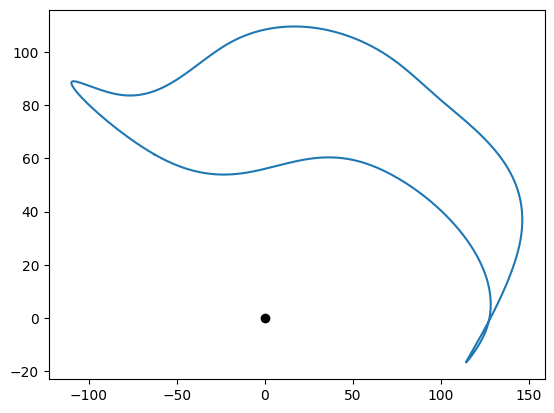

In [38]:
# après les différentes tentatives, on crée une fonction 'banane_alexis' dans le fichier 'fonctions _inertie' de telle sorte à pouvoir rapidement récupérer les coordonnées de l'enveloppe. voici son utilisation rapide :

banane=banane_alexis()
x_banane=[banane[i][0] for i in range(len(banane))]
y_banane=[banane[i][1] for i in range(len(banane))]
plt.scatter(0,0, color='k')
plt.plot(x_banane, y_banane)


In [39]:
atteinte_test=atteintes('2024_WttSmash_Singapour', 'ALEXIS-LEBRUN_vs_MA-LONG', precision_espace='oui', precision_frappe='oui')
print(atteinte_test[2], atteinte_test[3])

TypeError: 'list' object is not callable

In [40]:
(1-0.910958904109589)*146 - 8

5.0000000000000036